In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_pickle("../input/df_train.pkl")

use_cols = df_train.columns.values.tolist()
df_cat_cols = pd.read_csv("../input/cat_cols.csv", header=None)
cat_cols = df_cat_cols[0].values.tolist()
TARGET = "acsc_flag"
use_cols.remove(TARGET)

cat_cols = [col for col in cat_cols if col in use_cols]

print(df_train.shape)
df_train.head()

(1000000, 139)


,LOSD1,UNIT114,UNIT170,UNIT200,UNIT206,UNIT214,CHG001,CHG260,CHG480,CHG530,...,CC_GRP_10,TOT_GRP,totalcc,wgtcc,sex1,urstat1,race1,age,payor2,acsc_flag
0,1,0,0,0,0,0,746.029999,0.0,0.0,0.0,...,0,0,0,0,1,0,1,3,1,1
1,1,0,0,0,0,0,3240.000000,0.0,0.0,0.0,...,0,0,0,0,1,0,1,3,1,0
2,1,0,0,0,0,0,4861.000000,0.0,0.0,0.0,...,0,0,0,0,0,1,2,3,3,0
3,8,0,0,0,0,0,39665.949951,0.0,0.0,0.0,...,0,0,0,0,1,1,2,3,1,0
4,14,0,0,10,0,0,426110.000000,0.0,0.0,2130.0,...,0,0,0,0,1,1,2,3,1,0


In [3]:
cv= 3
kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
oof_pred = np.zeros(df_train.shape[0])
models = {}

param = {
    "objective": "binary",
    'metric': 'auc',
    'num_leaves': 64,
    'learning_rate': 0.03,
    'n_estimators': 3000,
    'subsample': 0.7,
    "feature_fraction": 0.3,
    "lambda_l1": 8,
    "lambda_l2": 8,
    "max_depth": 6,
    'seed': 42,
    'n_jobs': -1
}
    
for fold, (train_index, valid_index) in enumerate(kf.split(df_train, y = df_train[TARGET])):

    print("Traning on folder", fold, "...")
    X_train, X_valid = df_train.iloc[train_index][use_cols], df_train.iloc[valid_index][use_cols]
    y_train, y_valid = df_train.iloc[train_index][TARGET], df_train.iloc[valid_index][TARGET]
    
    model_lgb = lgb.LGBMRegressor(**param)
    
    model_lgb.fit(X_train, y_train,
                            eval_set=[(X_train, y_train), (X_valid, y_valid)],
                            categorical_feature=cat_cols,
                            early_stopping_rounds=200,
                            verbose=200)

    y_pred_valid = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration_)
    oof_pred[valid_index] = y_pred_valid
    
    models[fold] = model_lgb
    
print("-------------------------------------")
print("Overall AUC score is", roc_auc_score(df_train[TARGET], oof_pred))

Traning on folder 0 ...
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.998953	valid_1's auc: 0.998796
[400]	training's auc: 0.999596	valid_1's auc: 0.99929
[600]	training's auc: 0.999833	valid_1's auc: 0.999506
[800]	training's auc: 0.999912	valid_1's auc: 0.99963
[1000]	training's auc: 0.999946	valid_1's auc: 0.99968
[1200]	training's auc: 0.999965	valid_1's auc: 0.999707
[1400]	training's auc: 0.999975	valid_1's auc: 0.999719
[1600]	training's auc: 0.999981	valid_1's auc: 0.999719
[1800]	training's auc: 0.999985	valid_1's auc: 0.999723
[2000]	training's auc: 0.999987	valid_1's auc: 0.999725
[2200]	training's auc: 0.999989	valid_1's auc: 0.999728
[2400]	training's auc: 0.999989	valid_1's auc: 0.999735
[2600]	training's auc: 0.99999	valid_1's auc: 0.99974
[2800]	training's auc: 0.999991	valid_1's auc: 0.999743
[3000]	training's auc: 0.999991	valid_1's auc: 0.999746
Did not meet early stopping. Best iteration is:
[2994]	training's auc: 0.999991	va

In [4]:
feature_imp0 = pd.DataFrame(sorted(zip(models[0].feature_importances_,use_cols)), columns=["Value0", "Feature"])
feature_imp1 = pd.DataFrame(sorted(zip(models[1].feature_importances_,use_cols)), columns=["Value1", "Feature"])
feature_imp2 = pd.DataFrame(sorted(zip(models[2].feature_importances_,use_cols)), columns=["Value2", "Feature"])

feature_imp = feature_imp0.merge(feature_imp1, on='Feature').merge(feature_imp2, on='Feature')
feature_imp['Value'] = (feature_imp['Value0'] + feature_imp['Value1'] + feature_imp['Value2'])/3

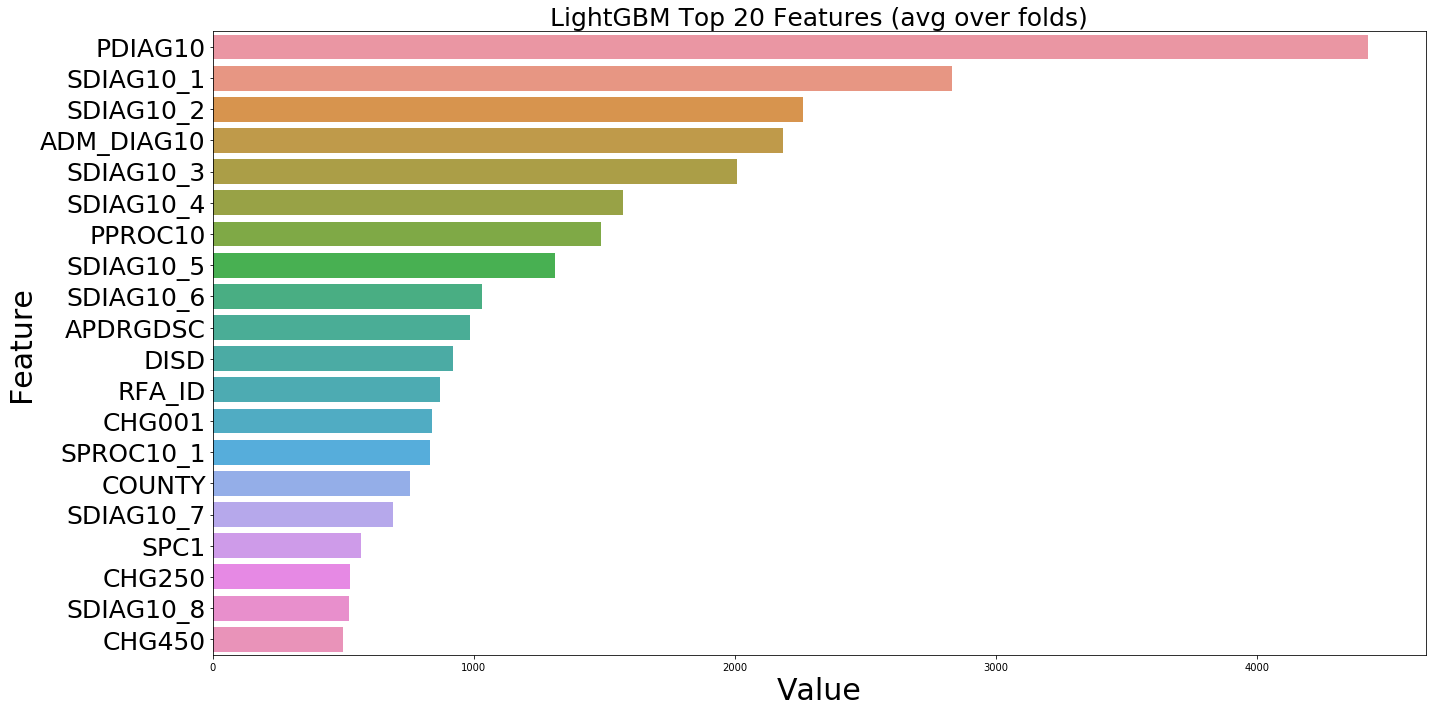

In [14]:
plt.figure(figsize=(20, 10))
b = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
_, ylabels = plt.yticks()
b.set_yticklabels(ylabels, size=25)
plt.title('LightGBM Top 20 Features (avg over folds)', fontsize=25)
plt.tight_layout()
plt.show()